In [73]:
# Librerias
import os
from bs4 import BeautifulSoup, NavigableString
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import re
from threading import Thread
import queue

In [74]:
# Parámetros
sourceDataFolder = "1-source-data"

bumeraniterationNumber = "5"
bumeranRootPath = sourceDataFolder + r"\main\bumeran\iteration-" + bumeraniterationNumber

intermFilesFolder = "2-intermediate-files"
mergedMainFolder = "3-results"
logsFolder = "4-logs"

dataVisualizationTopLimit = 20

counterIn = 0
counterOut = 0

In [75]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def find_nth_right(haystack, needle, n):
    start = haystack.rfind(needle)
    while start >= 0 and n > 1:
        start = haystack.rfind(needle, 0, start-len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  #if tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color }) is not None: 
  #  print(parseNames(parseLineBreaksAndAccents(tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color }).text)))
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( parseNames(parseLineBreaksAndAccents(findTags(tag, color).text)) == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Objetivo Laboral", "Experiencia Laboral", "Educacion", "Informatica", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def getStartAndEndIndex(sectionsIndexes, i):
  return sectionsIndexes[i], getNextSectionIndexValid(sectionsIndexes, i+1)

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

In [76]:
# Funciones principales
def getFiles(rootPath, source):
  # Obteniendo todas las carpetas de los perfiles
  folders = [f for f in os.listdir(rootPath) if os.path.isdir(os.path.join(rootPath, f))]

  # Definiendo la lista de archivos final
  files = []

  # Iterando sobre las carpetas
  for folder in folders:
    # Obteniendo los archivos por cada carpeta
    folderFiles = [os.path.join(rootPath, folder, f) for f in os.listdir(os.path.join(rootPath, folder)) if os.path.isfile(os.path.join(rootPath, folder, f))]

    # Agregando esos archivos a la lista de archivos final
    if folderFiles:
      files.extend(folderFiles)

  print("Archivos originales: " + str(len(files)))

  # Filtros específicos por cada origen
  if source == "bumeran":
    filesFiltered = [f for f in files if ("\Has recibido un CV para el aviso" in f)]
  else:
    filesFiltered = files

  print("Archivos filtrados solo con postulaciones: " + str(len(filesFiltered)))

  # Filtros para considerar un archivo especifico
  filterIsIn = [
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(76).html"
    #r"1-source-data\main\bumeran\iteration-4\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(110).html"
    #r"1-source-data\main\linkedin\iteration-2\bandeja-entrada\New application_ .NET Developer from Cesar Ospino.html"
    #r"1-source-data\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\a-considerar\Has recibido un CV para el aviso _Practicante de Infrastructure & Cloud_.html"
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad Sr. (Test Lead)_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(1).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista Programador_(6).html"
    #r"1-source-data\main\bumeran\iteration-4\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Analista de Sistemas_(24).html"
    # 5 casos con estudios en blanco
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Especialista en Analítica Jr_(50).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada\Has recibido un CV para el aviso _Gestor de Servicios de TI_(132).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(173).html",
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(71).html",
    #r"1-source-data\main\bumeran\iteration-4\ejecutivo-comercial\Has recibido un CV para el aviso _Ejecutivo Comercial TI_(38).html"
    #r"1-source-data\main\bumeran\iteration-4\bandeja-entrada-asistente-social\Has recibido un CV para el aviso _Asistente Social_(196).html"
    #r"1-source-data\main\bumeran\iteration-5\bandeja-entrada-2019-and-before\Has recibido un CV para el aviso _Desarrollador.NET_(1).html"
    #r"1-source-data\main\bumeran\iteration-5\bandeja-entrada-2019-and-before\Has recibido un CV para el aviso _Desarrollador. Net_(26).html"
    #r"1-source-data\main\bumeran\iteration-5\analista-funcional\Has recibido un CV para el aviso _Analista Funcional_(18).html"
    #r"1-source-data\main\bumeran\iteration-5\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(92).html"
    #r"1-source-data\main\bumeran\iteration-5\analista-calidad\Has recibido un CV para el aviso _Analista de Calidad_(108).html"
  ]
  filesFilteredIsIn = [f for f in filesFiltered if ( f in filterIsIn if filterIsIn else True )]

  # Filtros para omitir un archivo especifico
  filterIsNotIn = [
    # 3 archivos con data incompleta (se mantiene en iteracion 4 y 5)
    r"1-source-data\main\bumeran\iteration-5\bandeja-entrada-2022\Has recibido un CV para el aviso _Analista Programador Senior_Full Stack_(2).html",
    r"1-source-data\main\bumeran\iteration-5\bandeja-entrada-2022\Has recibido un CV para el aviso _Analista Programador_(6).html",
    r"1-source-data\main\bumeran\iteration-5\programador-net\Has recibido un CV para el aviso _Programador .Net Senior_(4).html",
  ]

  filesFilteredNotIn = [f for f in filesFilteredIsIn if ( f not in filterIsNotIn if filterIsNotIn else True )]

  print("Archivos filtrados solo con data completa: " + str(len(filesFilteredNotIn)))

  # Limites superiores e inferiores en la búsqueda de archivos
  startLimit = None
  topLimit = None
  filesFilteredLimits = filesFilteredNotIn[(startLimit-1 if startLimit else 0): (topLimit if topLimit else len(files))]

  return filesFilteredLimits

In [77]:
def getEncodingBumeran(file):
  candidateLog = ""

  encoding = "windows-1252"
  try:
    with open(file, "r", encoding="utf-16-le") as f:
      if "charset=unicode" in f.read():
        encoding = 'utf-16-le'
      else:
        raise Exception
  except Exception as e:
    try:
      with open(file, "r", encoding="windows-1252") as f:
        if "charset=windows-1252" in f.read():
          encoding = 'windows-1252'
        else:
          encoding = encoding
    except Exception as e:
      candidateLog = candidateLog + file + "\n"
      candidateLog = candidateLog + traceback.format_exc() + "\n"
      candidateLog = candidateLog + "\n"
      pass
      
  return encoding, candidateLog

In [78]:
def getCandidateBumeran(file, encoding, candidateLog):
  candidateData = {}
 
  try:
  # Abriendo el archivo
    with open(file, "r", encoding=encoding) as myFile:
      #Parseando el archivo html a soup
      soup = BeautifulSoup(myFile.read(), "lxml")

      # Obteniendo cada uno de los campos para la data

      # Fecha de postulación
      spanDates = soup.find_all("span", {"style": "color:black"})
      if len(spanDates) > 4:
        rawPostulationDate = spanDates[3].text
        postulationDate = datetime.datetime.strptime(spanDates[3].text, "%A, %B %d, %Y %I:%M %p")
      else:
        spanDates2 = soup.find_all("span", {"style": 'font-family:"Calibri",sans-serif;color:black'})
        rawPostulationDate = spanDates2[3].text
        postulationDate = datetime.datetime.strptime(spanDates2[3].text, "%A, %B %d, %Y %I:%M %p")
        
      candidateData["candidatePostulationDate"] = postulationDate.strftime("%A, %B %d, %Y %I:%M %p")

      # Definiendo los colores a usar para las búsquedas según las fechas
      # En la fecha 2020-06-11 cambio el color de los titulos de cada sección
      inflexionDate = datetime.datetime(2020,6,11,12,5,0)
      colorTitle, colorSections = ("#008599", "#2192C9") if postulationDate <= inflexionDate else ("#E90066", "#0A26EE")

      # Nombre del perfil
      candidateData["jobProfileName"] = parseNames(parseLineBreaksAndAccents(soup.findAll("span", {"style": ("color:" + colorTitle) })[0].text))

      liTags = soup.find_all("ul", {"type": "disc"})[0].find_all("li")

      # Nombre del candidato
      firstLinePased = parseNames(parseLineBreaksAndAccents(liTags[0].text))
      candidateData["candidateFullName"] = firstLinePased
      
      # Pais de residencia
      expectedCivilStatusValues = ["Soltero/A", "Casado/A", "Divorciado/A", "Pareja De Hecho", "Viudo/A", "Union Libre"]
      secondLineParsed = parseNames(parseLineBreaksAndAccents(liTags[1].text))
      firstcommaIndex = secondLineParsed.find(",")
      if firstcommaIndex != -1:
        candidateData["candidateResidenceCountry"] = secondLineParsed[:firstcommaIndex]
      else:
        candidateData["candidateResidenceCountry"] = ""

      # Estado civil
      civilStatus = ""
      for value in expectedCivilStatusValues:
        if value in secondLineParsed:
          civilStatus = value
      candidateData["candidateCivilStatus"] = civilStatus

      # Numero de documento
      # Propiedad especial del rfind, el -1 coincide con el inicio del string, por lo que es lo mismo tomarlo con o sin el indice, en caso el index no sea -1
      lastSpaceIndex = secondLineParsed.rfind(" ")
      candidateData["candidateDocumentNumber"] = re.sub("[^0-9]", "", secondLineParsed[lastSpaceIndex+1:])
      
      # Fecha de nacimiento
      thirdLineParsed = parseNames(parseLineBreaksAndAccents(liTags[2].text))
      birthDate = thirdLineParsed[thirdLineParsed.find(":")+2:]
      if birthDate != "":
        candidateData["candidateBirthDate"] = datetime.datetime.strptime(thirdLineParsed[thirdLineParsed.find(":")+2:], "%d-%m-%Y").strftime("%Y-%m-%d")
      else:
        candidateData["candidateBirthDate"] = ""

      # Pais de nacimiento
      fourthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[3].text))
      candidateData["candidateBirthCountry"] = fourthLineParsed[fourthLineParsed.find(":")+2:]

      #Dirección
      fifthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[4].text))
      candidateData["candidateAddress"] = fifthLineParsed
    
      # Telefonos
      sixthLineParsed = parseNames(parseLineBreaksAndAccents(liTags[5].text))
      candidateData["homeNumber"] = sixthLineParsed[sixthLineParsed.find("Tel.")+5:sixthLineParsed.find("/")]
      candidateData["cellphoneNumber"] = sixthLineParsed[sixthLineParsed.find("/")+2:]

      # Correo
      seventhLineParsed = parseNames(parseLineBreaksAndAccents(liTags[6].text))
      candidateData["email"] = seventhLineParsed

      mainDivTag = soup.find_all("div", {"style": 'background-position-x:50%;background-position-y:100%'})[0]
      mainChildTags = mainDivTag.find_all(recursive=False)
      sectionsIndexes = getSectionsIndexes(mainChildTags, colorSections)

      # Objetivo laboral, salario
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 0)
      if startIndex and endIndex:
        if (endIndex - startIndex) == 3:
          workObjectiveTag = mainChildTags[startIndex+2]
          candidateData["workObjetive"] = ""
          candidateData["salary"] = 0
          liTags = workObjectiveTag.find_all("li")
          for liTag in liTags:
            parsedText = parseNames(parseLineBreaksAndAccents(liTag.text))
            if "Objetivo Laboral:" in parsedText:
              candidateData["workObjetive"] = parsedText[parsedText.find("Objetivo Laboral: ")+18:]
            if "Sueldo Pretendido:" in parsedText:
              candidateData["salary"] = int(parsedText[parsedText.find("$")+1:parsedText.find(".")])
        else:
          candidateData["workObjetive"] = ""
          candidateData["salary"] = 0
      else:
        candidateData["workObjetive"] = ""
        candidateData["salary"] = 0
      
      # Experiencia laboral
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 1)

      if startIndex and endIndex:
        workExperienceTags = mainChildTags[startIndex+2:endIndex]
        
        # Iterando sobre todos los trabajos
        daysOfExperience = 0
        for index, firstRowIndex in enumerate(range(0, len(workExperienceTags), 2)):
          firstRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in workExperienceTags[firstRowIndex].find("span").findAll(string=True)]
          secondRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in workExperienceTags[firstRowIndex+1].find("p").findAll(string=True)]
          workStartDateText = firstRowTagsValues[0][:firstRowTagsValues[0].find(" - ")]
          workStartDate = datetime.datetime.strptime(workStartDateText, "%d-%m-%Y")
          workEndDateText = firstRowTagsValues[0][firstRowTagsValues[0].find(" - ")+3:firstRowTagsValues[0].find(" |")]
          workEndDate = datetime.datetime.strptime(workEndDateText, "%d-%m-%Y") if workEndDateText != "Presente" else postulationDate
          daysOfWork = abs((workEndDate - workStartDate).days)
          daysOfExperience = daysOfExperience + daysOfWork
          # Obteniendo datos del último trabajo
          if index == 0:
            candidateData["lastWorkDays"] = daysOfWork
            candidateData["lastWorkCompany"] = firstRowTagsValues[1]
            candidateData["lastWorkCountry"] = firstRowTagsValues[2][:firstRowTagsValues[2].find(".")]
            candidateData["lastWorkArea"] = firstRowTagsValues[2][firstRowTagsValues[2].find(".")+2:firstRowTagsValues[2].rfind(".")]
            candidateData["lastWorkName"] = secondRowTagsValues[0]
            candidateData["lastWorkDescription"] = secondRowTagsValues[1] if len (secondRowTagsValues) > 1 else ""
        candidateData["yearsOfExperience"] = int(daysOfExperience/365)
        candidateData["worksNumber"] = int(len(workExperienceTags)/2)
      else:
        raise Exception("561 errores mapeados (experiencia laboral)")
            
      # Carrera profesional (última alcanzada)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 2)
      if startIndex and endIndex:
        educationTags = mainChildTags[startIndex+2:endIndex]

        #['01-05-2016 - 01-07-2016 |', 'Galaxy Training', ', Peru.', 'Programacion', '.']
        #['Arquitectura De Aplicaciones Java Ee', ', Graduado, Otro.']

        #['01-01-2013 - Presente | , Peru. .']
        #['Java Web Developer', ', Graduado, Terciario/Tecnico.']

        #['01-03-2012 - Presente |', 'Instituto De Formacion Bancaria Ifb', ', Peru. .']
        #['Adminisracion Bancaria', ', Abandonado, Terciario/Tecnico.']

        # Iterando sobre todos las educaciones
        daysOfStudy = 0
        for index, firstRowIndex in enumerate(range(0, len(educationTags), 2)):
          firstRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in educationTags[firstRowIndex].find("span").findAll(string=True)]
          secondRowTagsValues = [parseNames(parseLineBreaksAndAccents(tagValue)) for tagValue in educationTags[firstRowIndex+1].find("p").findAll(string=True)]
          educationStartDateText = firstRowTagsValues[0][:firstRowTagsValues[0].find(" - ")]
          educationStartDate = datetime.datetime.strptime(educationStartDateText, "%d-%m-%Y")
          educationEndDateText = firstRowTagsValues[0][firstRowTagsValues[0].find(" - ")+3:firstRowTagsValues[0].find(" |")]
          educationEndDate = datetime.datetime.strptime(educationEndDateText, "%d-%m-%Y") if educationEndDateText != "Presente" else postulationDate
          daysOfEducation = abs((educationEndDate - educationStartDate).days)
          daysOfStudy = daysOfStudy + daysOfEducation
          # Obteniendo datos del último trabajo
          if index == 0:
            candidateData["lastEducationDays"] = daysOfEducation
            candidateData["lastEducationCompany"] = firstRowTagsValues[1]
            candidateData["lastEducationCountry"] = firstRowTagsValues[2][firstRowTagsValues[2].find(",")+2:firstRowTagsValues[2].find(".")]
            candidateData["lastEducationArea"] = firstRowTagsValues[3]

            firstElemSecondRow = secondRowTagsValues[0] if len(secondRowTagsValues) == 2 else "".join([secondRowTagsValues[0], secondRowTagsValues[1]])
            secondElemSecondRow = secondRowTagsValues[1] if len(secondRowTagsValues) == 2 else secondRowTagsValues[2]

            #candidateData["str"] = str(secondRowTagsValues)
            #candidateData["len"] = len(secondRowTagsValues)
            candidateData["lastEducationName"] = firstElemSecondRow
            candidateData["lastEducationStatus"] = secondElemSecondRow[secondElemSecondRow.find(",")+2:secondElemSecondRow.rfind(",")]
            candidateData["lastEducationDegree"] = secondElemSecondRow[secondElemSecondRow.rfind(",")+2:secondElemSecondRow.find(".")]
        candidateData["yearsOfStudy"] = int(daysOfStudy/365)
        candidateData["studiesNumber"] = int(len(educationTags)/2)
      else:
        raise Exception("121 errores mapeados (educación)")
      
      # Habilidades técnicas
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 3)
      #print(startIndex, endIndex)
      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        liTags = mainChildTags[startIndex+2].find_all("li")
        candidateData["technicalSkills"] = len(liTags)
      else:
        candidateData["technicalSkills"] = 0
      
      # Lenguajes
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 4)

      if startIndex and endIndex:
        # Falta mejorar la validación (algunos tienen solo u, solo carrera o ninguno)
        liTags = mainChildTags[startIndex+2].find_all("li")
        candidateData["languages"] = len(liTags)
      else:
        candidateData["languages"] = 0

      # Otros conocimientos (habilidades blandas)
      startIndex, endIndex = getStartAndEndIndex(sectionsIndexes, 5)

      if startIndex and endIndex:
        liTags = mainChildTags[startIndex+2].find_all("li")
        candidateData["otherSkills"] = len(liTags)
      else:
        candidateData["otherSkills"] = 0

  except Exception as e:
    candidateData = {}
    candidateLog = candidateLog + str(file) + "\n"
    candidateLog = candidateLog + traceback.format_exc() + "\n"
    candidateLog = candidateLog + "\n"
    pass

  return candidateData, candidateLog

In [79]:
class Worker(Thread):
  def __init__(self, queue, filesCount):
    Thread.__init__(self)
    self.queue = queue
    self.filesCount = filesCount
    self.candidateData = []
    self.candidateLog = []

  def run(self):
    while True:
      elem = self.queue.get()
      if not elem:
        break
      
      index, file = elem["index"], elem["file"]

      if index % 500 == 0:
        print(str(index) + "/" + str(self.filesCount) + " archivos analizados")
      
      # Obteniendo el encoding por cada archivo
      encoding, candidateLog = getEncodingBumeran(file)

      # Obteniendo los datos por cada archivo
      candidateData, candidateLog = getCandidateBumeran(file, encoding, candidateLog)
      
      if candidateData:
        self.candidateData.append(candidateData)
      if candidateLog:
        self.candidateLog.append(candidateLog)

      self.queue.task_done()

In [80]:
def iterateCandidateQueue(files, workersNumber):
  filesCount = len(files)

  q = queue.Queue()
  for index, file in enumerate(files):
    q.put({"index": index, "file": file})
  
  for _ in range(workersNumber):
    q.put({})
  
  workers = []
  for _ in range(workersNumber):
      worker = Worker(q, filesCount)
      worker.start()
      workers.append(worker)
  
  for worker in workers:
      worker.join()
  
  data = []
  log = ""
  for worker in workers:
    data.extend(worker.candidateData)
    log = log + "".join(worker.candidateLog)

  return data, log

In [81]:
def readAndWriteMain(source):
  # Definiendo la carpeta raiz de los archivos a buscar, según el origen
  rootPath = bumeranRootPath

  # Obteniendo la lista de archivos, según el origen
  files = getFiles(rootPath, source)

  # Definiendo el numero de hilos
  workersNumber = 1

  # Obteniendo los datos de candidatos y el log
  data, log = iterateCandidateQueue(files, workersNumber)

  # Realizando un ordenamiento por fecha de postulación, en orden descendente
  #data = sorted(data, key=lambda x: (x["candidatePostulationDate"]), reverse=True)

  # Escribiendo la data de los candidatos (json y csv)
  writeJson(data, os.path.join(intermFilesFolder, source + '.json'))
  writeCsv(data, os.path.join(intermFilesFolder, source + '.csv'))

  # Escribiendo el log de errores
  writeTxt(log, os.path.join(logsFolder, source, datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S") + ".txt"), 'utf-16')

  return data

In [82]:
def readAndWriteMergedMain(mainData):
  mergedMainData = []
  for elem in mainData:
    if (elem):
      mergedMainData.extend(elem)

  writeJson(mergedMainData, os.path.join(mergedMainFolder, "result.json"), 'utf-8')
  writeCsv(mergedMainData, os.path.join(mergedMainFolder, "result.csv"), 'utf-8')

  return mergedMainData

In [83]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.count())

  columns = [elem for elem in df.columns if elem not in ["candidatePostulationDate", "candidateFullName"]]

  for column in columns:
    topDf = df[column].value_counts()[:dataVisualizationTopLimit]
    print(topDf)
    y_axis = list(reversed(topDf.index))
    x_axis = list(reversed(topDf.values))
    plt.ylabel(column)
    plt.barh(y_axis, x_axis)
    plt.show()

Inicio: 2023-05-19 23:20:03.034212
Se inició el procesamiento
Archivos originales: 10230
Archivos filtrados solo con postulaciones: 10228
Archivos filtrados solo con data completa: 10225
0/10225 archivos analizados
500/10225 archivos analizados
1000/10225 archivos analizados
1500/10225 archivos analizados
2000/10225 archivos analizados
2500/10225 archivos analizados
3000/10225 archivos analizados
3500/10225 archivos analizados
4000/10225 archivos analizados
4500/10225 archivos analizados
5000/10225 archivos analizados
5500/10225 archivos analizados
6000/10225 archivos analizados
6500/10225 archivos analizados
7000/10225 archivos analizados
7500/10225 archivos analizados
8000/10225 archivos analizados
8500/10225 archivos analizados
9000/10225 archivos analizados
9500/10225 archivos analizados
10000/10225 archivos analizados
Se terminó de procesar Bumeran
Se terminó de unir la data principal
candidatePostulationDate     9467
jobProfileName               9467
candidateFullName            

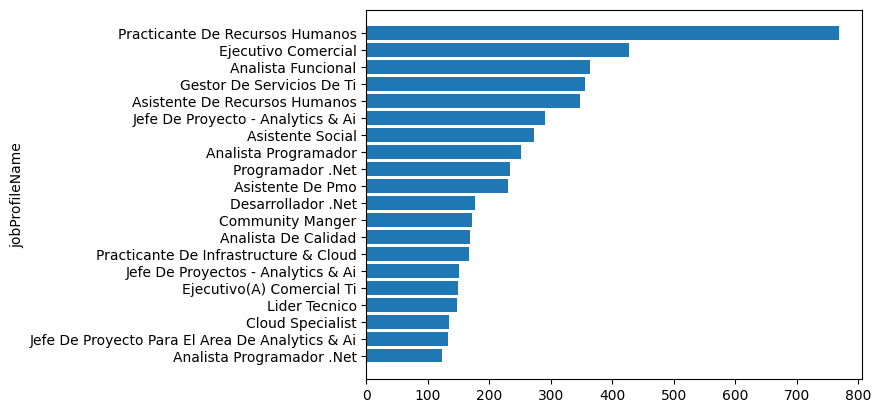

Peru                    9236
Venezuela                142
                          54
Argentina                 11
Colombia                   9
Brasil                     4
Ecuador                    3
Bolivia                    1
Francia                    1
Costa Rica                 1
Republica Dominicana       1
Chile                      1
Espana                     1
Panama                     1
El Salvador                1
Name: candidateResidenceCountry, dtype: int64


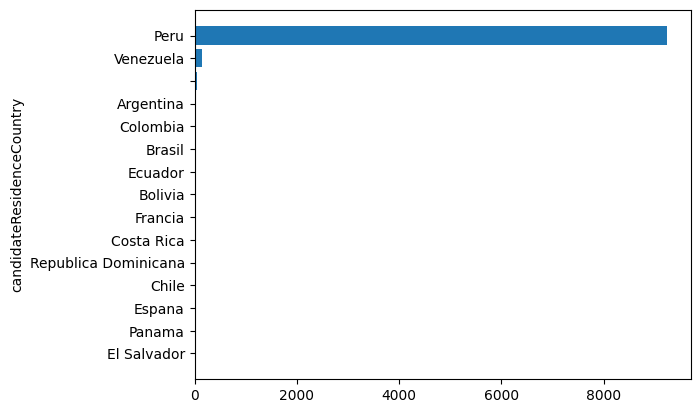

Soltero/A          7296
Casado/A           1444
                    451
Divorciado/A        123
Pareja De Hecho     105
Union Libre          45
Viudo/A               3
Name: candidateCivilStatus, dtype: int64


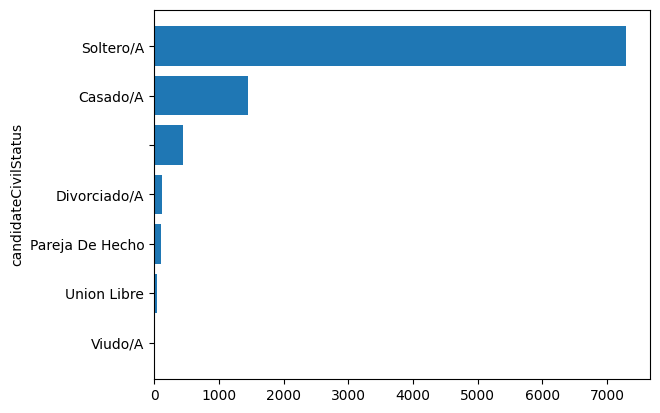

            185
43319681     78
43462768     35
41002160     27
18229064     23
45732690     21
43015660     20
10315458     18
45419217     17
42030318     15
12345678     15
44174897     14
46596341     14
40613584     14
44178991     13
07968889     13
47088768     13
70008340     13
40539275     12
46688979     12
Name: candidateDocumentNumber, dtype: int64


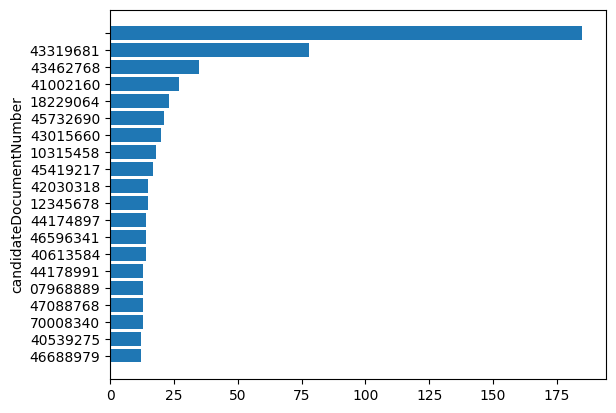

              142
1985-07-13     84
1979-09-30     42
1986-01-18     25
1978-01-21     23
1989-02-25     22
1985-04-08     20
1975-05-15     18
1990-12-15     17
1988-11-18     17
1990-09-11     17
1987-04-13     16
1982-10-16     15
1980-07-24     14
1990-02-24     14
1968-10-29     13
1988-08-17     13
1987-01-01     13
1980-11-05     12
1980-05-03     12
Name: candidateBirthDate, dtype: int64


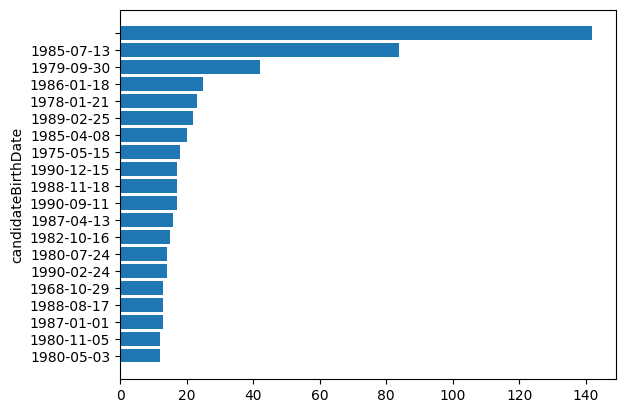

Peru                    9236
Venezuela                142
                          54
Argentina                 11
Colombia                   9
Brasil                     4
Ecuador                    3
Bolivia                    1
Francia                    1
Costa Rica                 1
Republica Dominicana       1
Chile                      1
Espana                     1
Panama                     1
El Salvador                1
Name: candidateBirthCountry, dtype: int64


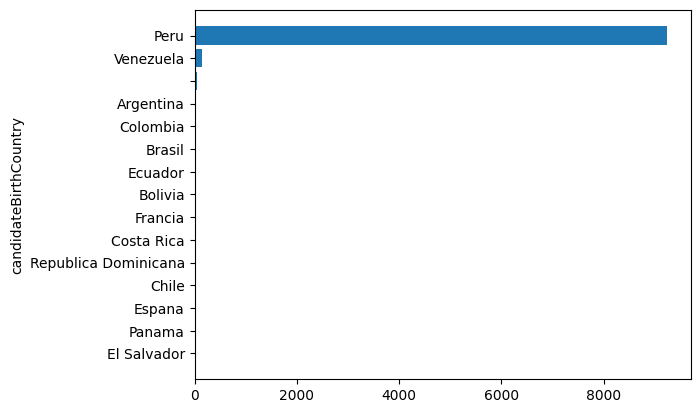

                                                                                        491
Lima, Lima, Lima, Peru                                                                   74
Neruda, Lima, Lima, Peru                                                                 46
., Lima, Lima, Peru                                                                      32
Jr Ica 950, Lima, Lima, Peru                                                             26
Calle Valladolid # 128 Urbanizacion Mayorazgo - Ate, Ate, Lima, Peru                     25
Santa Anita , Lima, Lima, Peru                                                           24
Calle 13 De Abril 910, Arequipa, Arequipa, Peru                                          21
Calera De La Merced 248, Surquillo, Lima, Peru                                           20
Begonias, Carabayllo, Lima, Peru                                                         17
-, Lima, Lima, Peru                                                             

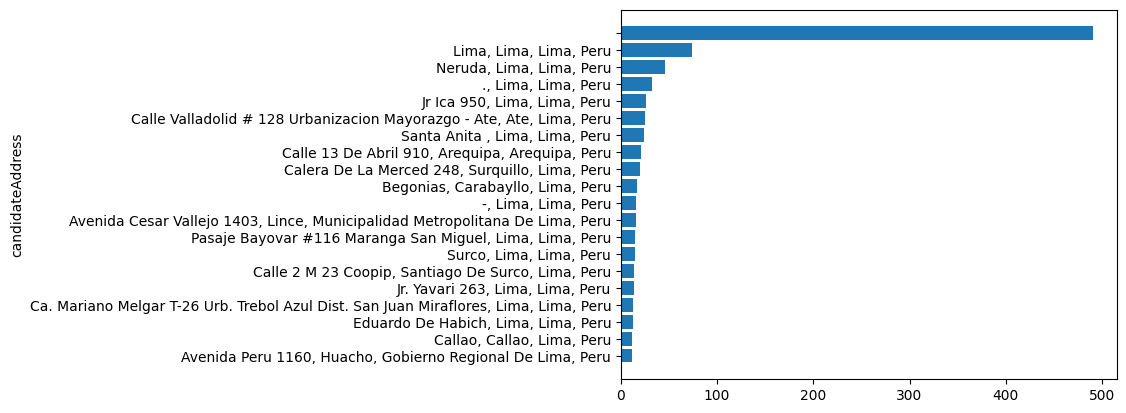

                 4384
51                635
+                 119
01                 77
511                63
51 910984054       45
51 931810142       24
+51                15
511 5748571        14
51 995384149       13
01 2580077         12
01 0               11
511 4342693        11
5775611 01         11
51 993596249        9
01 3997952          9
51 5611445          9
01 4643843          9
051 7473619         9
1                   8
Name: homeNumber, dtype: int64


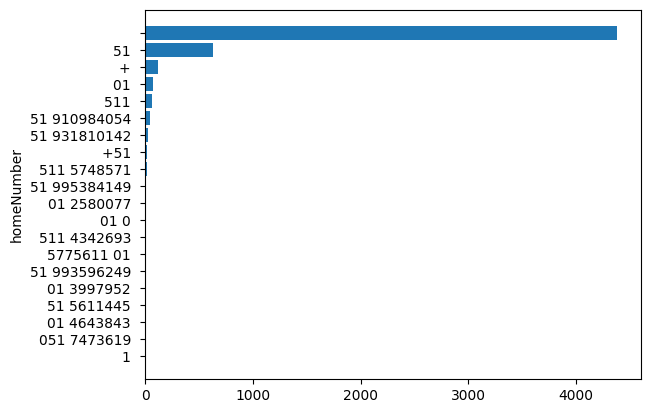

51 910984054           45
                       33
511 949346218          27
51 931810142           24
054 973583947          21
+51 950001939          20
51 994637675           18
51 949346218           15
51 997671135           15
511 992028085          14
0511 933480280         14
51 940442936           14
51 995384149           13
511 946059246          13
01 959053787           13
51 991064075           12
951901566              11
511 958960663          11
932458838 932458838    10
51-1 997671135         10
Name: cellphoneNumber, dtype: int64


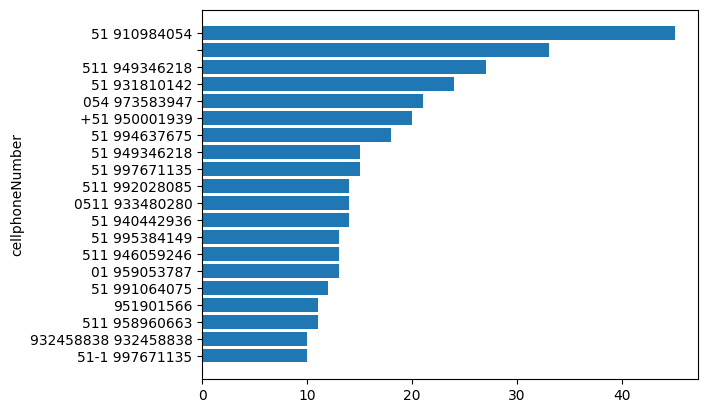

Jurqui29@Outlook.Com            78
Hcortez2011@Gmail.Com           42
Amirandac36@Gmail.Com           35
Gastoni21@Hotmail.Com           23
Alevca@Hotmail.Com              21
Villamoralesjulia@Gmail.Com     20
Paco150575@Hotmail.Com          18
Asistemas200920341@Gmail.Com    17
Ricardo_I14@Hotmail.Com         17
Eduardopassano82@Hotmail.Com    15
John.Panana@Gmail.Com           14
Renato.Mzc1990@Gmail.Com        14
Leono13@Live.Com                14
Guillermoherenciav@Gmail.Com    13
Rosa.Huirset@Gmail.Com          13
Willy.Olortegui@Gmail.Com       13
Pjrcb@Yahoo.Es                  12
Nirvana_566@Hotmail.Com         12
Alez1512@Hotmail.Com            12
Randy.Silva@Gmail.Com           11
Name: email, dtype: int64


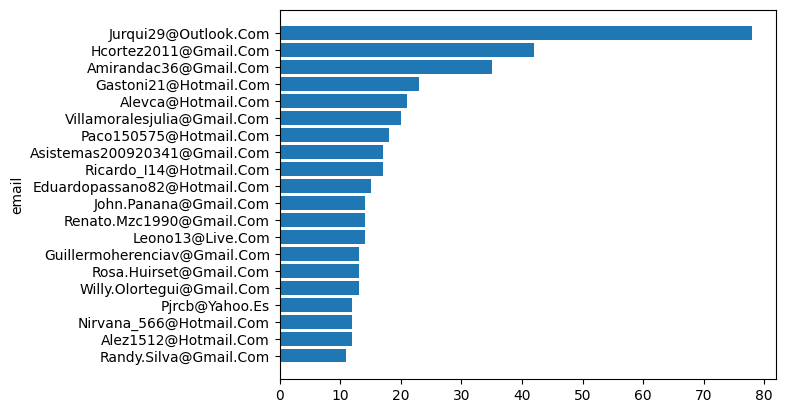

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          941
Me Desempeno En El Area De

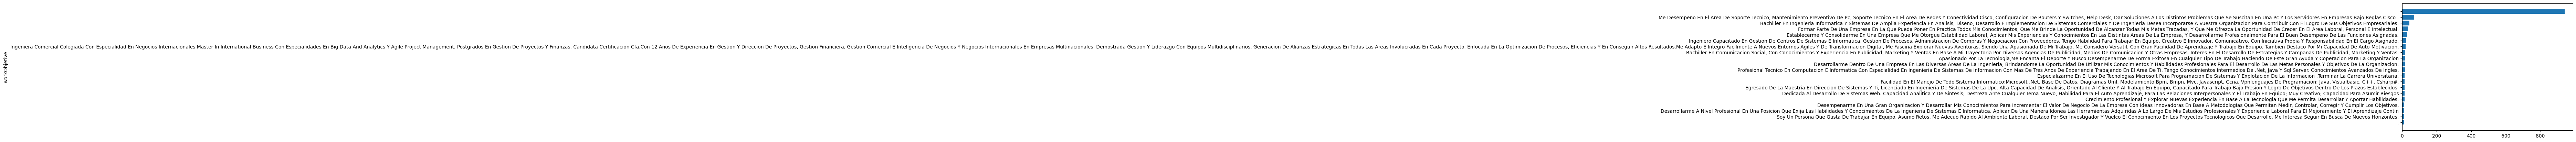

5000    604
2500    586
2000    564
3500    543
3000    538
4000    516
1500    441
6000    428
4500    395
1800    343
1200    304
0       296
5500    295
7000    271
6500    268
1000    227
1025    206
8000    195
1       194
930     174
Name: salary, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3696\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


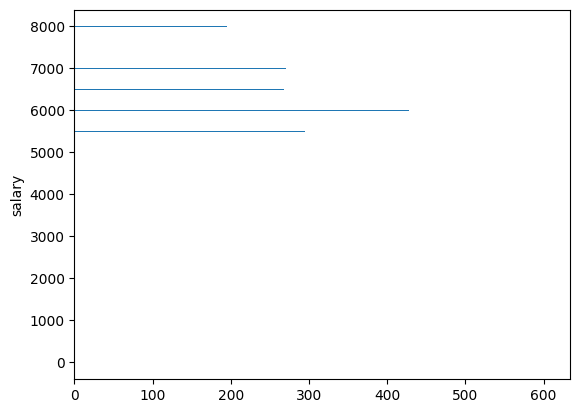

61     157
153    152
92     150
122    144
365    131
184    101
31      88
212     86
91      81
214     81
334     79
151     79
181     78
273     73
183     69
275     62
366     62
243     58
59      58
182     56
Name: lastWorkDays, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3696\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


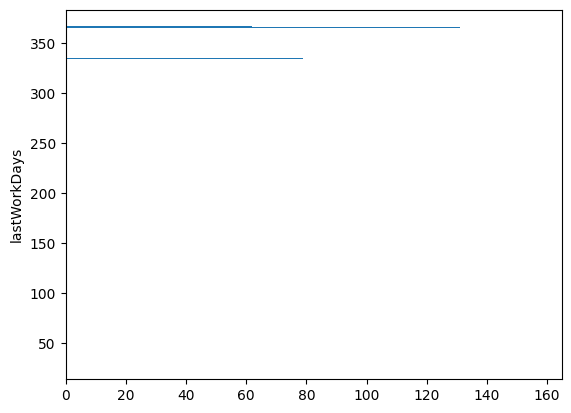

Canvia                                      131
Freelance (Clientes)                         78
Global Hitss                                 68
Everis                                       56
Independiente                                55
Mdp Consulting                               52
Indra                                        48
Tata Consultancy Services                    38
Banco De Credito Del Peru                    37
Everis Peru Sac                              33
Pontificia Universidad Catolica Del Peru     26
Experis                                      25
Everis Peru                                  24
Tgestiona                                    24
Onpe                                         23
Telefonica Del Peru                          22
Freelance                                    22
Mdp                                          22
Farmacias Peruanas                           21
Telefonica                                   21
Name: lastWorkCompany, dtype: int64


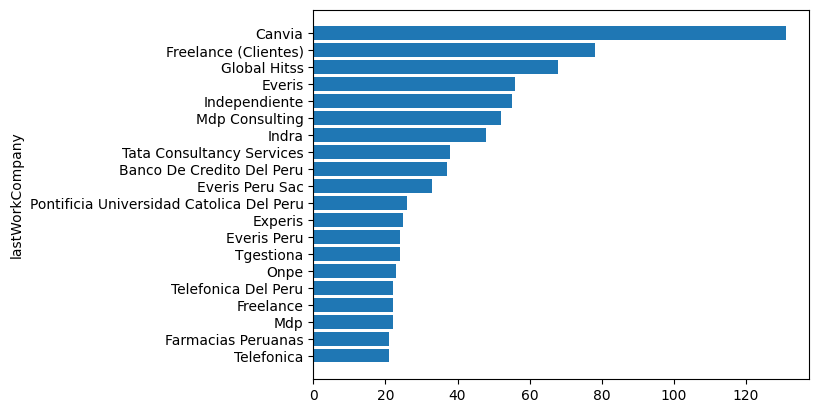

Peru              9293
Estados Unidos      31
Venezuela           25
Espana              23
Colombia            17
Brasil              16
Chile               11
Argentina            7
Ecuador              7
Mexico               4
Albania              3
Reino Unido          3
Costa Rica           3
Finlandia            2
Australia            2
Francia              2
Italia               2
Paises Bajos         2
Panama               2
Pakistan             1
Name: lastWorkCountry, dtype: int64


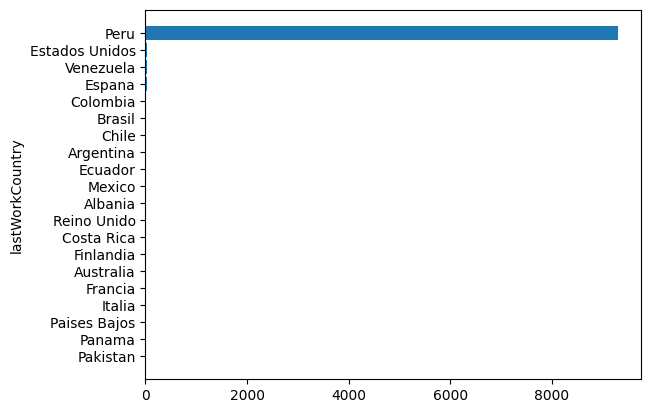

Tecnologia / Sistemas            1027
Tecnologias De La Informacion    1013
Liderazgo De Proyecto             582
Programacion                      570
Comercial                         533
Sistemas                          485
Recursos Humanos                  430
Ventas                            255
Administracion                    255
Analisis De Datos                 231
Analisis Funcional                220
Infraestructura                   213
Soporte Tecnico                   189
Atencion Al Cliente               162
Seguridad Informatica             155
Otras Ingenierias                 149
Desarrollo De Negocios            129
Testing / Qa / Qc                 127
Administracion De Personal        115
Telecomunicaciones                115
Name: lastWorkArea, dtype: int64


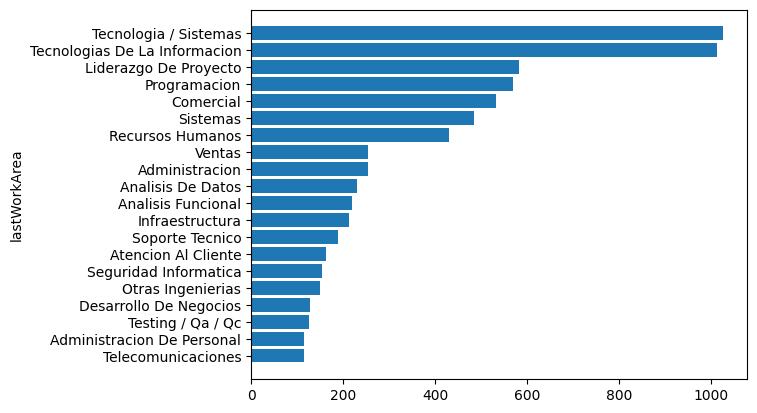

Analista Programador                            389
Analista De Sistemas                            190
Analista Funcional                              119
Jefe De Proyectos                                82
Trabajadora Social                               79
Supervisor De Infraestructura De Redes Cisco     78
Asistente Administrativo                         69
Project Manager                                  54
Asesor Comercial                                 54
Practicante                                      50
Ejecutivo Comercial                              49
Asistente De Recursos Humanos                    49
Analista                                         48
Analista De Sistemas Senior                      47
Key Account Manager                              38
Jefe De Sistemas                                 37
Programador                                      37
Lider Tecnico                                    35
Asistente De Sistemas                            35
Soporte Tecn

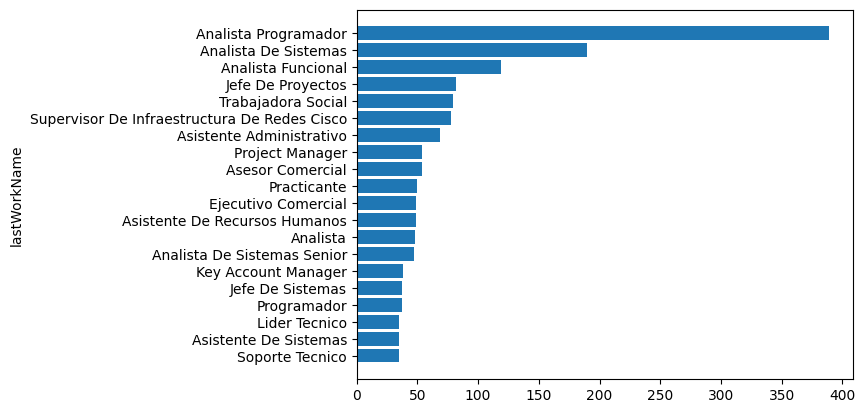

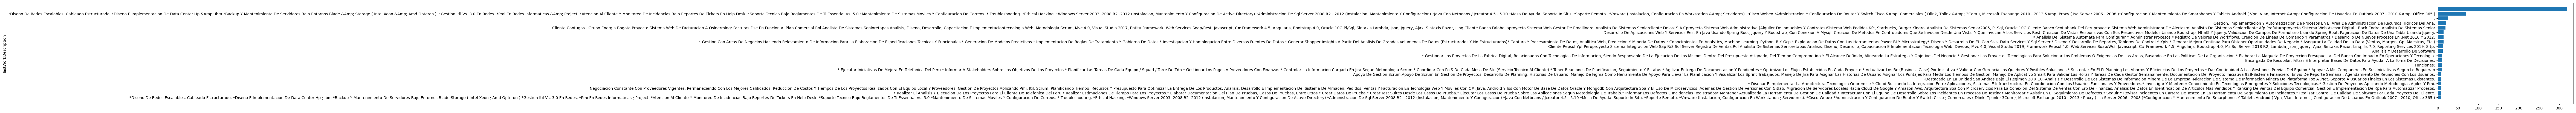

4     726
5     685
8     672
7     661
6     647
2     628
1     622
3     616
0     574
9     527
10    492
11    420
12    303
13    300
15    255
14    246
16    173
17    127
19    110
18    104
Name: yearsOfExperience, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3696\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


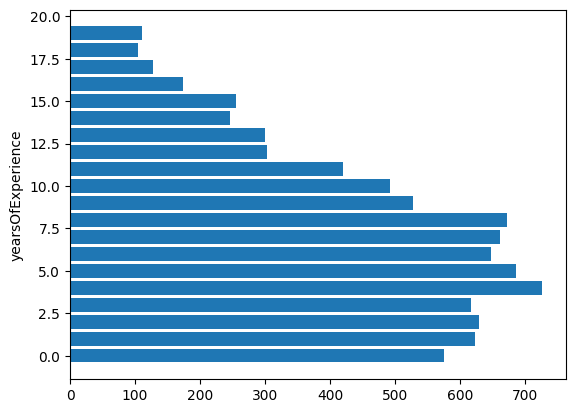

5     1282
4     1174
6     1033
3     1000
7      926
8      729
2      712
1      610
9      523
10     405
11     271
12     238
13     148
14     117
15      90
17      59
16      45
19      35
18      29
20      15
Name: worksNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3696\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


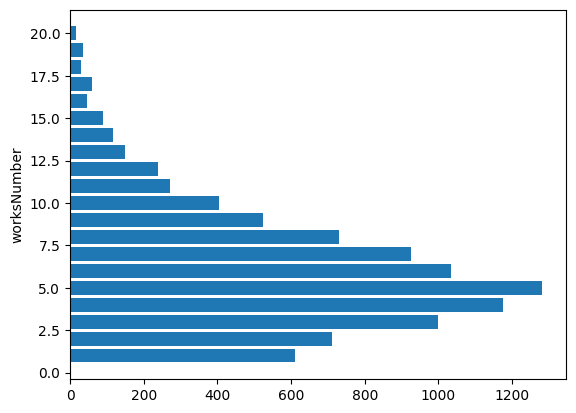

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3696\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


0       563
31      302
61      229
30      203
1736    189
92      150
1705    136
122     135
1948    121
153     119
2101     95
1795     94
91       87
1826     78
183      65
1157     63
123      59
1218     59
1675     59
2070     57
Name: lastEducationDays, dtype: int64


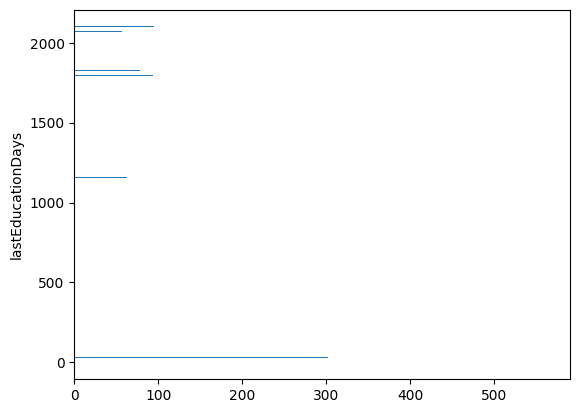

Universidad Peruana De Ciencias Aplicadas    498
Universidad Tecnologica Del Peru             332
Pontificia Universidad Catolica Del Peru     309
Universidad Nacional Mayor De San Marcos     276
Upc                                          271
Universidad Privada Del Norte                271
Universidad Esan                             232
Cibertec                                     204
Universidad Cesar Vallejo                    199
Universidad De Lima                          195
Instituto Cibertec                           195
Universidad Nacional De Ingenieria           179
Universidad De San Martin De Porres          177
Universidad Ricardo Palma                    168
Universidad Nacional Federico Villarreal     168
Universidad Inca Garcilaso De La Vega        167
Isil                                         160
Utp                                          150
Universidad San Ignacio De Loyola            134
Tecsup                                       120
Name: lastEducationC

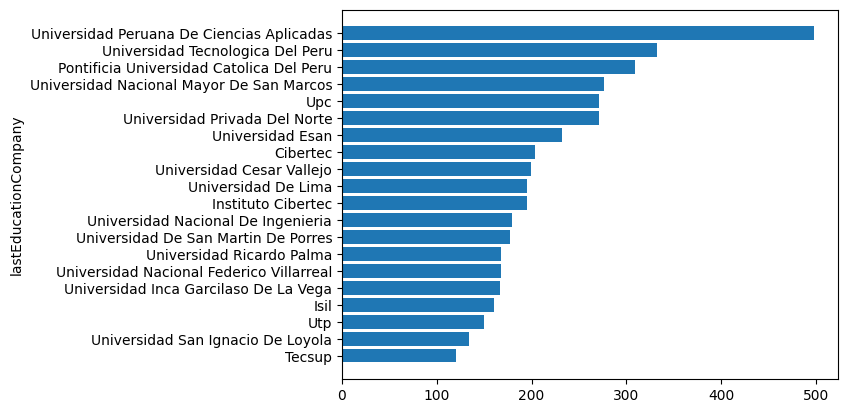

Peru              8869
Espana             194
Venezuela          160
Estados Unidos      76
Mexico              32
Colombia            19
Argentina           19
Chile               18
Brasil              18
Costa Rica          14
Canada               8
Ecuador              6
Francia              5
Bolivia              5
Australia            4
India                3
Alemania             3
Internacional        2
Reino Unido          2
Cuba                 2
Name: lastEducationCountry, dtype: int64


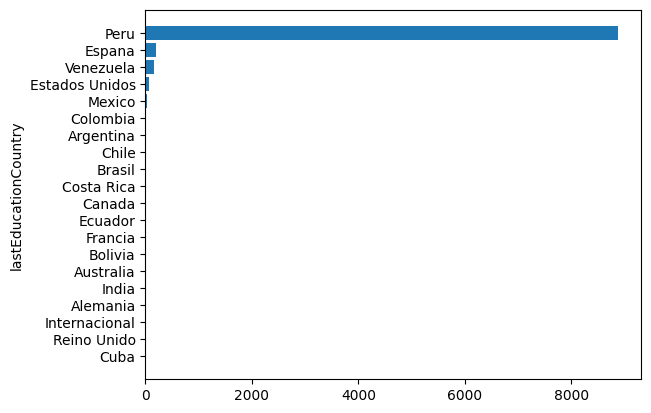

Ing. En Sistemas                  2176
Tecnologias De La Informacion     1213
Adm. De Empresas                  1079
Ing. Informatica                   576
Ing. Industrial                    444
Computacion / Informatica          436
Marketing / Comercializacion       361
Recursos Humanos / Relac. Ind.     343
Otra                               331
Psicologia                         287
Ing. - Otros                       177
Trabajo Social                     136
Analisis De Sistemas               135
Telecomunicaciones                 118
Ing. Telecomunicaciones            115
Programacion                       114
Procesos / Calidad Total           104
Finanzas                            93
Bachiller                           88
Ing. Electronica                    73
Name: lastEducationArea, dtype: int64


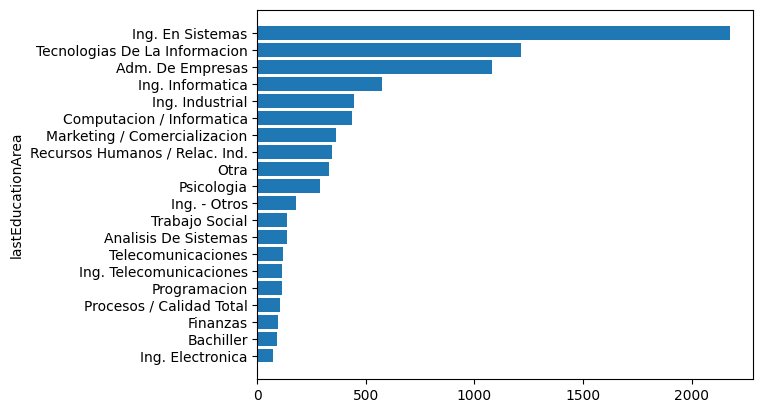

Ingenieria De Sistemas                       718
Ingenieria Industrial                        236
Psicologia                                   201
Administracion De Empresas                   182
Ingeniero De Sistemas                        176
Computacion E Informatica                    149
Ingenieria De Sistemas E Informatica         134
Administracion                               106
Bachiller En Ingenieria De Sistemas           90
Mba                                           62
Trabajo Social                                62
Ingenieria De Redes Y Comunicaciones          61
Ingles                                        53
Ingenieria Informatica                        52
Marketing                                     51
Ingenieria De Computacion Y Sistemas          48
Ingenieria De Software                        45
Bachiller                                     43
Administracion Y Negocios Internacionales     43
Ingeniero De Sistemas E Informatica           42
Name: lastEducationN

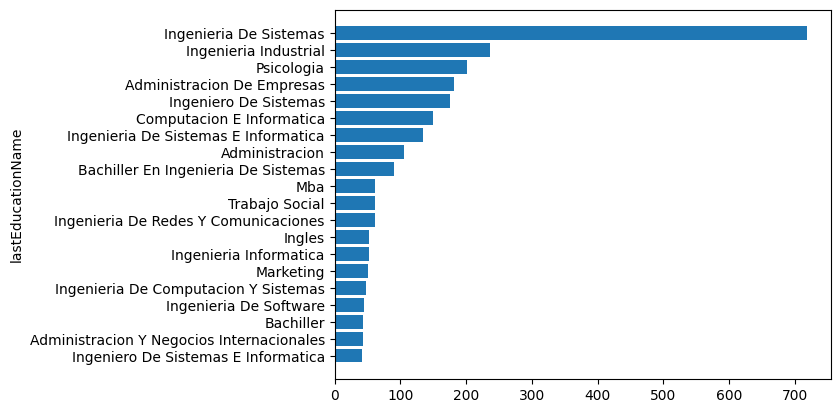

Graduado      6390
En Curso      2922
Abandonado     154
                 1
Name: lastEducationStatus, dtype: int64


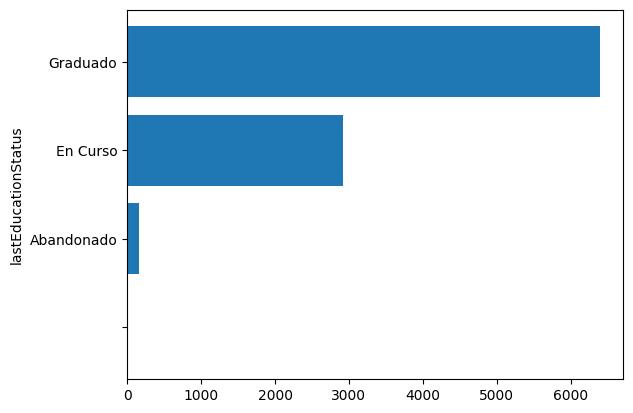

Universitario        4531
Otro                 2216
Posgrado             1170
Terciario/Tecnico     929
Master                600
Doctorado              13
Secundario              8
Name: lastEducationDegree, dtype: int64


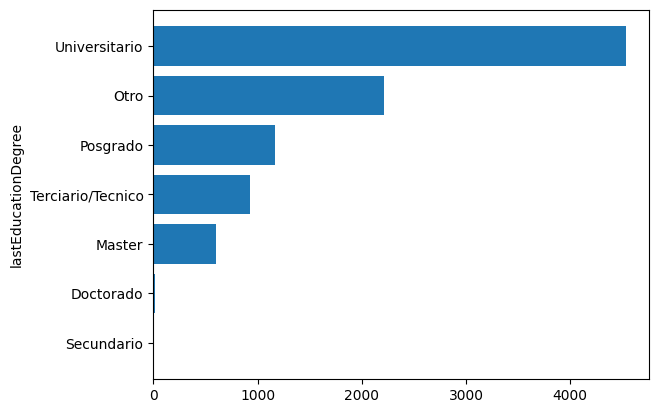

5     1554
6     1304
4     1193
7     1134
8      863
9      580
3      542
10     463
11     332
2      251
12     251
13     184
14     127
15     105
16      83
1       74
0       70
18      58
19      51
20      47
Name: yearsOfStudy, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3696\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


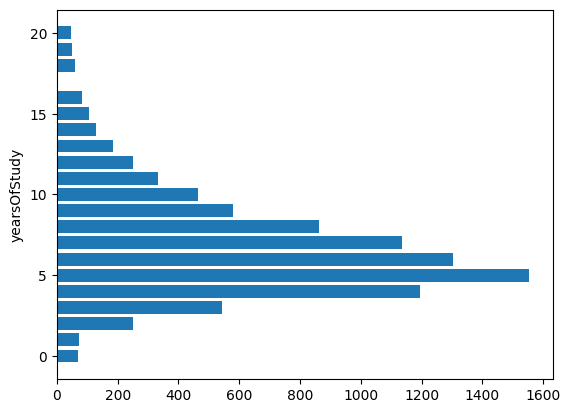

1     3308
2     2278
3     1148
4      701
5      461
6      421
7      282
8      190
9      141
11     116
10      89
12      69
14      53
13      43
16      25
15      22
20      19
18      17
17      17
19      14
Name: studiesNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3696\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


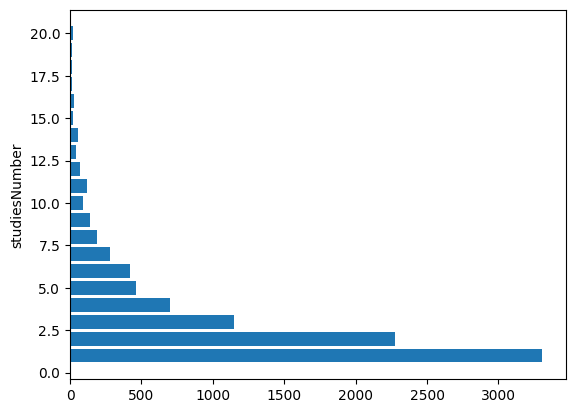

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3696\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


1     1048
0      970
3      793
2      747
4      622
5      539
6      482
7      455
9      423
8      401
10     324
11     323
12     247
13     238
16     224
14     179
15     155
17     125
18     115
21      91
Name: technicalSkills, dtype: int64


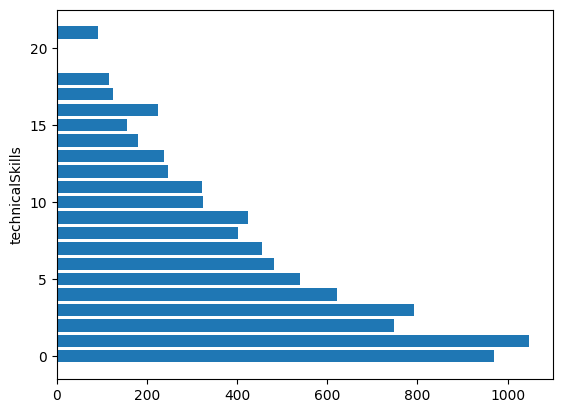

1    6751
2    1816
0     568
3     279
4      52
5       1
Name: languages, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3696\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


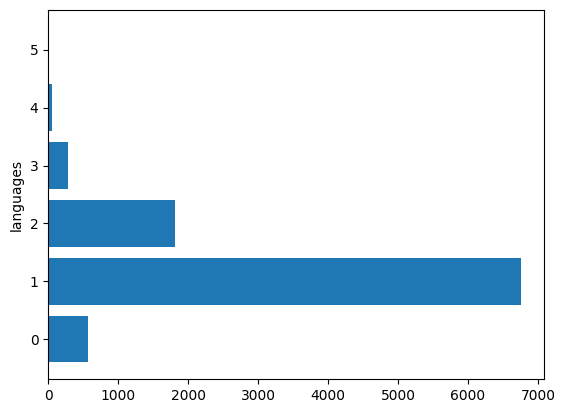

0     1994
1     1627
2     1098
3      791
4      706
5      619
6      477
7      413
8      329
9      270
10     206
11     169
12     137
13     110
14      89
15      68
17      49
16      47
20      34
18      30
Name: otherSkills, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_3696\3874036009.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  topDf = df[column].value_counts()[:dataVisualizationTopLimit]


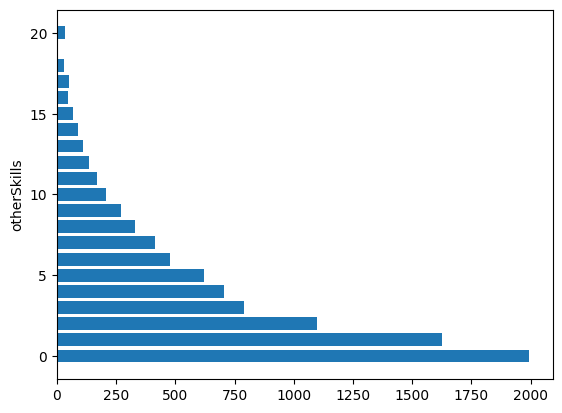

Fin: 2023-05-19 23:22:03.721321
Tiempo: 0:02:00.687109


In [84]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  # El dataset principal que sea el de bumeran
  # Los otros archivos que solo se usen para actualizar la variable objetivo
  # Esto porque los otros orígenes están incompletos y costaría llenar los campos (incluso el excel que se hizo)
  isLoadedBumeran = False
  isMergedMain = False
  #False

  # Leyendo o calculando bumeran
  bumeranData = readJson(os.path.join(intermFilesFolder, 'bumeran.json')) if isLoadedBumeran else readAndWriteMain('bumeran')
  print("Se terminó de procesar Bumeran")

  # Uniendo la data principal (bumeran + linkedin (ya no))
  mergedMainData = readJson(os.path.join(mergedMainFolder, 'result.json')) if isMergedMain else readAndWriteMergedMain([bumeranData])
  print("Se terminó de unir la data principal")

  visualizeData(mergedMainData)
  
  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

  #print(counterIn)
  #print(counterOut)

if __name__ == "__main__":
  main()